In [1]:
!git clone https://github.com/roulupen/ERAV4.git

Cloning into 'ERAV4'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 90 (delta 37), reused 78 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 12.07 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("🟢 Running on Google Colab")
except ImportError:
    IN_COLAB = False
    print("🟢 Running locally")

# Install required packages if on Colab
if IN_COLAB:
    %pip install albumentations torchsummary
    print("📦 Packages installed")
else:
    print("📦 Using local packages")


🟢 Running on Google Colab
📦 Packages installed


In [4]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from ERAV4.assignment7.model import create_cifar10_model
from ERAV4.assignment7.data import get_cifar10_data_loaders, get_dataset_info, visualize_augmentations
from ERAV4.assignment7.trainer import create_trainer
from ERAV4.assignment7.utils import set_random_seed, get_device, plot_training_history
from ERAV4.assignment7.config import TrainingConfig

print("✅ All imports successful")


✅ All imports successful


In [5]:
# Set random seed for reproducibility
set_random_seed(42)

# Get device (will use GPU if available)
device = get_device()

# Print device information
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Version: {torch.version.cuda}")
    print(f"🔧 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    print(f"🔧 MPS Available: {torch.backends.mps.is_available()}")

# Training configuration
config = TrainingConfig(
    batch_size=64,
    epochs=50,
    learning_rate=0.001,
    optimizer='adamw',
    scheduler='cyclic',
    dropout=0.05,
    augment=True,
    target_accuracy=85.0
)

print(f"⚙️  Configuration: {config.batch_size} batch size, {config.epochs} epochs, {config.learning_rate} LR, {config.dropout} dropout")


🌱 Random seed set to 42
✅ Using CUDA GPU: Tesla T4
🖥️  Device: cuda
🔧 CUDA Version: 12.6
🔧 GPU Memory: 15.8 GB
⚙️  Configuration: 64 batch size, 50 epochs, 0.001 LR, 0.05 dropout


In [6]:
# Load CIFAR-10 dataset
print("📥 Loading CIFAR-10 dataset...")
train_loader, test_loader = get_cifar10_data_loaders(
    batch_size=config.batch_size,
    num_workers=2 if IN_COLAB else 4,  # Use fewer workers on Colab
    augment=config.augment,
    pin_memory=None  # Auto-detect based on device
)

print(f"✅ Data loaded successfully")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {config.batch_size}")
print(f"  Augmentation: {'✅' if config.augment else '❌'}")


📥 Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:19<00:00, 8.65MB/s]


✅ Data loaded successfully
  Training batches: 781
  Test batches: 157
  Batch size: 64
  Augmentation: ✅


📊 CIFAR-10 Dataset Information:
  Classes: 10
  Input size: (3, 32, 32)
  Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


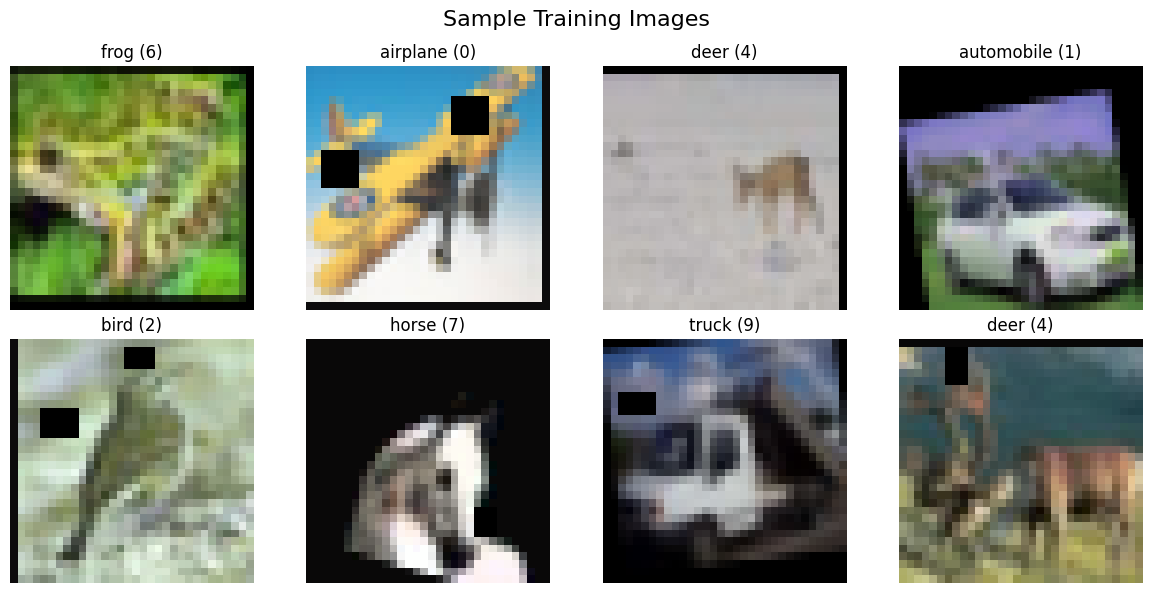

In [7]:
# Display sample images from the dataset
def display_sample_images(data_loader, num_samples=8, title="Sample Images"):
    """Display sample images from the dataset."""
    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Select first num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Convert to numpy for visualization
    images = images.numpy()

    # Denormalize images
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images * std.reshape(1, 3, 1, 1) + mean.reshape(1, 3, 1, 1)
    images = np.clip(images, 0, 1)

    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        # Transpose from CHW to HWC
        img = images[i].transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'{dataset_info["class_names"][labels[i]]} ({labels[i]})')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Get dataset information
dataset_info = get_dataset_info()
print("📊 CIFAR-10 Dataset Information:")
print(f"  Classes: {dataset_info['num_classes']}")
print(f"  Input size: {dataset_info['input_size']}")
print(f"  Class names: {dataset_info['class_names']}")

# Display sample images
display_sample_images(train_loader, title="Sample Training Images")


In [8]:
# Model parameter analysis
def analyze_model_parameters(model):
    """Analyze and display model parameters by block."""
    print("📊 Model Parameter Analysis:")
    print("=" * 50)

    total_params = 0
    block_params = {}

    # Count parameters for each block
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and module.weight is not None:
            param_count = module.weight.numel()
            if hasattr(module, 'bias') and module.bias is not None:
                param_count += module.bias.numel()

            total_params += param_count

            # Categorize by block
            if 'block1' in name:
                block_params['Block 1 (Standard Conv)'] = block_params.get('Block 1 (Standard Conv)', 0) + param_count
            elif 'block2' in name:
                block_params['Block 2 (Depthwise Sep)'] = block_params.get('Block 2 (Depthwise Sep)', 0) + param_count
            elif 'block3' in name:
                block_params['Block 3 (Dilated Conv)'] = block_params.get('Block 3 (Dilated Conv)', 0) + param_count
            elif 'block4' in name:
                block_params['Block 4 (Dilated Conv)'] = block_params.get('Block 4 (Dilated Conv)', 0) + param_count
            elif 'transition' in name:
                block_params['Transition Blocks'] = block_params.get('Transition Blocks', 0) + param_count
            elif 'fc' in name:
                block_params['Final FC Layer'] = block_params.get('Final FC Layer', 0) + param_count

    # Display parameter breakdown
    for block_name, params in block_params.items():
        percentage = (params / total_params) * 100
        print(f"{block_name:25}: {params:8,} params ({percentage:5.1f}%)")

    print("-" * 50)
    print(f"{'Total Parameters':25}: {total_params:8,} params (100.0%)")
    print(f"{'Under 200k limit':25}: {'✅' if total_params < 200000 else '❌'}")

    # Memory usage estimation
    memory_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32
    print(f"{'Estimated Memory':25}: {memory_mb:5.1f} MB")

    return total_params, block_params


In [10]:
# Create and analyze the model
print("🏗️ Creating CIFAR-10 Model...")
model = create_cifar10_model(
    num_classes=config.num_classes,
    dropout=config.dropout
)

# Move model to device
model = model.to(device)
print(f"✅ Model created and moved to {device}")

# Display model summary
print("\n📊 Model Summary:")
from ERAV4.assignment7.utils import get_model_summary
get_model_summary(model, input_size=(3, 32, 32))


🏗️ Creating CIFAR-10 Model...
✅ Model created and moved to cuda

📊 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              30
            Conv2d-2           [-1, 32, 32, 32]             128
DepthwiseSeparableConv2d-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
         Dropout2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             320
            Conv2d-8           [-1, 64, 32, 32]           2,112
DepthwiseSeparableConv2d-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        Dropout2d-12           [-1, 64, 32, 32]               0
         

In [11]:
# Setup optimizer and scheduler
print("⚙️  Setting up training components...")

# Optimizer
if config.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
elif config.optimizer == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
elif config.optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=config.momentum)

# Scheduler
if config.scheduler == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=config.T_0, T_mult=1, eta_min=config.eta_min
    )
elif config.scheduler == 'cyclic':
    scheduler = optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=config.base_lr,
        max_lr=config.max_lr,
        step_size_up=config.step_size_up,
        step_size_down=config.step_size_down,
        mode=config.mode,
        gamma=config.gamma,
        scale_fn=config.scale_fn,
        scale_mode=config.scale_mode,
        cycle_momentum=config.cycle_momentum,
        base_momentum=config.base_momentum,
        max_momentum=config.max_momentum
    )
elif config.scheduler == 'step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
elif config.scheduler == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Loss function
criterion = nn.NLLLoss()

print(f"✅ Optimizer: {config.optimizer.upper()}")
print(f"✅ Scheduler: {config.scheduler}")
print(f"✅ Loss: NLLLoss")
print(f"✅ Learning Rate: {config.learning_rate}")
print(f"✅ Weight Decay: {config.weight_decay}")
print(f"✅ Dropout: {config.dropout}")

if config.scheduler == 'cyclic':
    print(f"🔄 CLR Base LR: {config.base_lr}")
    print(f"🔄 CLR Max LR: {config.max_lr}")
    print(f"🔄 CLR Step Size: {config.step_size_up}/{config.step_size_down}")
    print(f"🔄 CLR Mode: {config.mode}")

# Create trainer
trainer = create_trainer(
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    config=config.to_dict()
)

print("✅ Trainer created successfully")


⚙️  Setting up training components...
✅ Optimizer: ADAMW
✅ Scheduler: cyclic
✅ Loss: NLLLoss
✅ Learning Rate: 0.001
✅ Weight Decay: 0.0001
✅ Dropout: 0.05
🔄 CLR Base LR: 0.0001
🔄 CLR Max LR: 0.01
🔄 CLR Step Size: 4/4
🔄 CLR Mode: triangular
🔧 Model moved to device: cuda:0
✅ Trainer created successfully


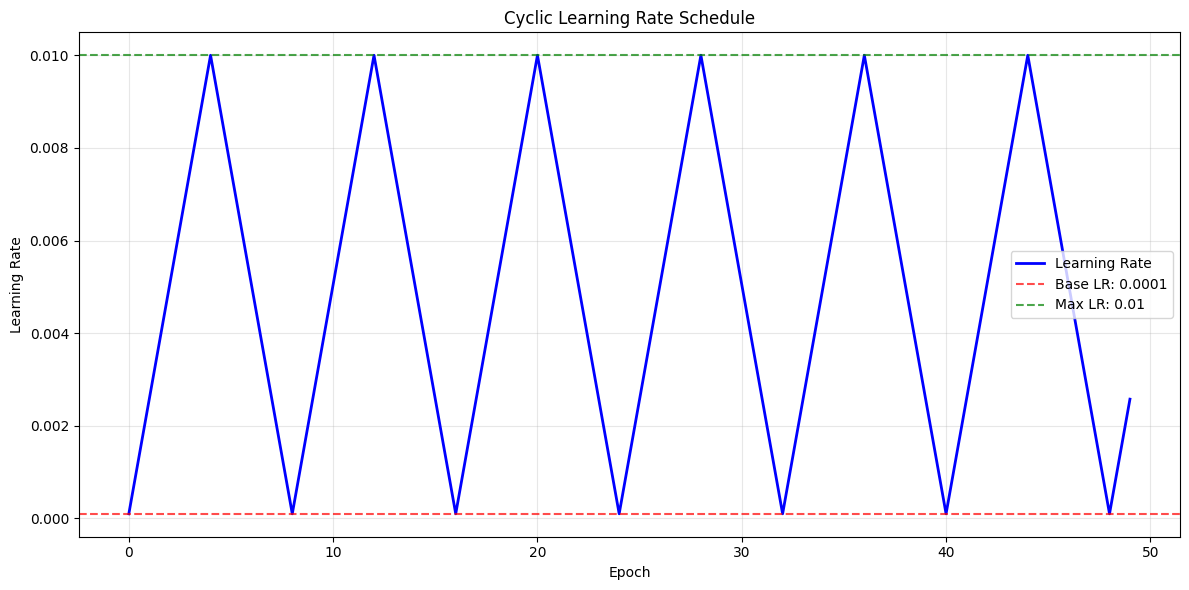

📊 Learning Rate Schedule:
  Base LR: 0.0001
  Max LR: 0.01
  Cycle Length: 8 epochs
  Mode: triangular


In [12]:
# Visualize learning rate schedule
def plot_learning_rate_schedule():
    """Plot the learning rate schedule for the cyclic scheduler."""
    if config.scheduler == 'cyclic':
        # Create a temporary scheduler to visualize the LR schedule
        temp_optimizer = optim.AdamW([torch.tensor(1.0, requires_grad=True)], lr=config.learning_rate)
        temp_scheduler = optim.lr_scheduler.CyclicLR(
            temp_optimizer,
            base_lr=config.base_lr,
            max_lr=config.max_lr,
            step_size_up=config.step_size_up,
            step_size_down=config.step_size_down,
            mode=config.mode,
            gamma=config.gamma,
            scale_fn=config.scale_fn,
            scale_mode=config.scale_mode,
            cycle_momentum=config.cycle_momentum,
            base_momentum=config.base_momentum,
            max_momentum=config.max_momentum
        )

        # Simulate learning rate changes
        lrs = []
        for epoch in range(config.epochs):
            lrs.append(temp_optimizer.param_groups[0]['lr'])
            temp_scheduler.step()

        # Plot the learning rate schedule
        plt.figure(figsize=(12, 6))
        plt.plot(range(config.epochs), lrs, 'b-', linewidth=2, label='Learning Rate')
        plt.axhline(y=config.base_lr, color='r', linestyle='--', alpha=0.7, label=f'Base LR: {config.base_lr}')
        plt.axhline(y=config.max_lr, color='g', linestyle='--', alpha=0.7, label=f'Max LR: {config.max_lr}')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Cyclic Learning Rate Schedule')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"📊 Learning Rate Schedule:")
        print(f"  Base LR: {config.base_lr}")
        print(f"  Max LR: {config.max_lr}")
        print(f"  Cycle Length: {config.step_size_up + config.step_size_down} epochs")
        print(f"  Mode: {config.mode}")
    else:
        print(f"📊 Current scheduler: {config.scheduler} (no visualization available)")

# Plot the learning rate schedule
plot_learning_rate_schedule()


In [13]:
# Start training
print(f"🚀 Starting training for {config.epochs} epochs...")
print(f"⏰ Training started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Target accuracy: {config.target_accuracy}%")
print("=" * 60)

# Train the model
training_history = trainer.train(
    num_epochs=config.epochs,
    early_stopping_patience=config.early_stopping_patience,
    min_delta=config.min_delta,
    checkpoint_dir='./checkpoints',
    scheduler_type=config.scheduler,
    verbose=True
)

print("\n✅ Training completed!")


🚀 Starting training for 50 epochs...
⏰ Training started at: 2025-10-02 07:22:41
🎯 Target accuracy: 85.0%
📁 Directory structure created in: ./checkpoints
🚀 Starting training for 50 epochs...
⏰ Training started at: 2025-10-02 07:22:41
📁 Checkpoint directory: ./checkpoints


Epoch  1/50 | Train: 1.9341 (24.89%) | Test: 1.6645 (36.65%) | LR: 0.007525 | Time: 46.6s
  🏆 New best model saved! (Test Acc: 36.65%)


Epoch  2/50 | Train: 1.6855 (37.13%) | Test: 1.4260 (46.59%) | LR: 0.005050 | Time: 46.5s
  🏆 New best model saved! (Test Acc: 46.59%)


Epoch  3/50 | Train: 1.4979 (45.16%) | Test: 1.3522 (51.38%) | LR: 0.002575 | Time: 47.6s
  🏆 New best model saved! (Test Acc: 51.38%)


Epoch  4/50 | Train: 1.3557 (50.94%) | Test: 1.0942 (60.10%) | LR: 0.010000 | Time: 46.3s
  🏆 New best model saved! (Test Acc: 60.10%)


Epoch  5/50 | Train: 1.2478 (55.16%) | Test: 1.0046 (64.35%) | LR: 0.002575 | Time: 46.4s
  🏆 New best model saved! (Test Acc: 64.35%)


Epoch  6/50 | Train: 1.1692 (58.21%) | Test: 0.9516 (66.69%) | LR: 0.005050 | Time: 45.9s
  🏆 New best model saved! (Test Acc: 66.69%)


Epoch  7/50 | Train: 1.0931 (61.25%) | Test: 0.8933 (68.65%) | LR: 0.007525 | Time: 46.2s
  🏆 New best model saved! (Test Acc: 68.65%)


Epoch  8/50 | Train: 1.0346 (63.54%) | Test: 0.8749 (68.87%) | LR: 0.000100 | Time: 46.2s
  🏆 New best model saved! (Test Acc: 68.87%)


Epoch  9/50 | Train: 0.9888 (65.01%) | Test: 0.8363 (70.75%) | LR: 0.007525 | Time: 46.8s
  🏆 New best model saved! (Test Acc: 70.75%)


Epoch 10/50 | Train: 0.9419 (66.95%) | Test: 0.7405 (73.88%) | LR: 0.005050 | Time: 46.6s
  🏆 New best model saved! (Test Acc: 73.88%)


Epoch 11/50 | Train: 0.9050 (68.08%) | Test: 0.7157 (75.30%) | LR: 0.002575 | Time: 46.1s
  🏆 New best model saved! (Test Acc: 75.30%)


Epoch 12/50 | Train: 0.8768 (69.46%) | Test: 0.7028 (75.78%) | LR: 0.010000 | Time: 46.8s
  🏆 New best model saved! (Test Acc: 75.78%)


Epoch 13/50 | Train: 0.8515 (70.58%) | Test: 0.6579 (77.23%) | LR: 0.002575 | Time: 46.2s
  🏆 New best model saved! (Test Acc: 77.23%)


Epoch 14/50 | Train: 0.8219 (71.28%) | Test: 0.6345 (78.48%) | LR: 0.005050 | Time: 46.6s
  🏆 New best model saved! (Test Acc: 78.48%)


Epoch 15/50 | Train: 0.7986 (72.35%) | Test: 0.6417 (78.07%) | LR: 0.007525 | Time: 47.1s
  ⏳ No improvement (1/10)


Epoch 16/50 | Train: 0.7837 (72.92%) | Test: 0.5846 (80.00%) | LR: 0.000100 | Time: 46.4s
  🏆 New best model saved! (Test Acc: 80.00%)


Epoch 17/50 | Train: 0.7661 (73.54%) | Test: 0.6198 (78.55%) | LR: 0.007525 | Time: 46.7s
  ⏳ No improvement (1/10)


Epoch 18/50 | Train: 0.7425 (74.37%) | Test: 0.5890 (79.97%) | LR: 0.005050 | Time: 46.8s
  ⏳ No improvement (2/10)


Epoch 19/50 | Train: 0.7308 (74.72%) | Test: 0.5675 (80.65%) | LR: 0.002575 | Time: 46.9s
  🏆 New best model saved! (Test Acc: 80.65%)


Epoch 20/50 | Train: 0.7199 (75.16%) | Test: 0.5448 (81.34%) | LR: 0.010000 | Time: 46.2s
  🏆 New best model saved! (Test Acc: 81.34%)


Epoch 21/50 | Train: 0.7082 (75.38%) | Test: 0.5520 (81.33%) | LR: 0.002575 | Time: 47.2s
  ⏳ No improvement (1/10)


Epoch 22/50 | Train: 0.6958 (75.86%) | Test: 0.5377 (81.62%) | LR: 0.005050 | Time: 47.0s
  🏆 New best model saved! (Test Acc: 81.62%)


Epoch 23/50 | Train: 0.6849 (76.06%) | Test: 0.5178 (82.30%) | LR: 0.007525 | Time: 46.2s
  🏆 New best model saved! (Test Acc: 82.30%)


Epoch 24/50 | Train: 0.6760 (76.65%) | Test: 0.5015 (82.86%) | LR: 0.000100 | Time: 46.3s
  🏆 New best model saved! (Test Acc: 82.86%)


Epoch 25/50 | Train: 0.6623 (77.04%) | Test: 0.4979 (82.58%) | LR: 0.007525 | Time: 45.8s
  ⏳ No improvement (1/10)


Epoch 26/50 | Train: 0.6537 (77.51%) | Test: 0.4997 (82.98%) | LR: 0.005050 | Time: 47.0s
  🏆 New best model saved! (Test Acc: 82.98%)


Epoch 27/50 | Train: 0.6455 (77.72%) | Test: 0.4856 (83.49%) | LR: 0.002575 | Time: 45.8s
  🏆 New best model saved! (Test Acc: 83.49%)


Epoch 28/50 | Train: 0.6408 (77.78%) | Test: 0.4870 (83.67%) | LR: 0.010000 | Time: 46.6s
  🏆 New best model saved! (Test Acc: 83.67%)


Epoch 29/50 | Train: 0.6364 (77.80%) | Test: 0.4692 (84.08%) | LR: 0.002575 | Time: 47.0s
  🏆 New best model saved! (Test Acc: 84.08%)


Epoch 30/50 | Train: 0.6234 (78.48%) | Test: 0.4656 (84.34%) | LR: 0.005050 | Time: 46.3s
  🏆 New best model saved! (Test Acc: 84.34%)


Epoch 31/50 | Train: 0.6137 (78.86%) | Test: 0.4550 (84.63%) | LR: 0.007525 | Time: 46.7s
  🏆 New best model saved! (Test Acc: 84.63%)


Epoch 32/50 | Train: 0.6099 (78.84%) | Test: 0.4586 (84.44%) | LR: 0.000100 | Time: 46.9s
  ⏳ No improvement (1/10)


Epoch 33/50 | Train: 0.6107 (78.84%) | Test: 0.4587 (84.35%) | LR: 0.007525 | Time: 46.4s
  ⏳ No improvement (2/10)


Epoch 34/50 | Train: 0.6012 (79.31%) | Test: 0.4467 (84.55%) | LR: 0.005050 | Time: 46.6s
  ⏳ No improvement (3/10)


Epoch 35/50 | Train: 0.5982 (79.38%) | Test: 0.4525 (84.46%) | LR: 0.002575 | Time: 46.0s
  ⏳ No improvement (4/10)


Epoch 36/50 | Train: 0.5835 (79.72%) | Test: 0.4365 (85.10%) | LR: 0.010000 | Time: 46.8s
  🏆 New best model saved! (Test Acc: 85.10%)


Epoch 37/50 | Train: 0.5836 (79.88%) | Test: 0.4414 (84.97%) | LR: 0.002575 | Time: 46.2s
  ⏳ No improvement (1/10)


Epoch 38/50 | Train: 0.5809 (80.00%) | Test: 0.4418 (85.06%) | LR: 0.005050 | Time: 47.7s
  ⏳ No improvement (2/10)


Epoch 39/50 | Train: 0.5682 (80.24%) | Test: 0.4223 (85.71%) | LR: 0.007525 | Time: 46.1s
  🏆 New best model saved! (Test Acc: 85.71%)


Epoch 40/50 | Train: 0.5719 (80.34%) | Test: 0.4578 (84.83%) | LR: 0.000100 | Time: 46.4s
  ⏳ No improvement (1/10)


Epoch 41/50 | Train: 0.5615 (80.79%) | Test: 0.4312 (85.36%) | LR: 0.007525 | Time: 46.9s
  ⏳ No improvement (2/10)


Epoch 42/50 | Train: 0.5591 (80.65%) | Test: 0.4119 (85.94%) | LR: 0.005050 | Time: 46.0s
  🏆 New best model saved! (Test Acc: 85.94%)


Epoch 43/50 | Train: 0.5538 (80.96%) | Test: 0.4195 (85.97%) | LR: 0.002575 | Time: 46.5s
  🏆 New best model saved! (Test Acc: 85.97%)


Epoch 44/50 | Train: 0.5517 (81.07%) | Test: 0.4329 (85.40%) | LR: 0.010000 | Time: 46.8s
  ⏳ No improvement (1/10)


Epoch 45/50 | Train: 0.5437 (81.25%) | Test: 0.4165 (86.18%) | LR: 0.002575 | Time: 46.5s
  🏆 New best model saved! (Test Acc: 86.18%)


Epoch 46/50 | Train: 0.5452 (81.21%) | Test: 0.4195 (85.70%) | LR: 0.005050 | Time: 46.6s
  ⏳ No improvement (1/10)


Epoch 47/50 | Train: 0.5371 (81.57%) | Test: 0.4149 (86.12%) | LR: 0.007525 | Time: 45.8s
  ⏳ No improvement (2/10)


Epoch 48/50 | Train: 0.5355 (81.43%) | Test: 0.3927 (87.02%) | LR: 0.000100 | Time: 46.4s
  🏆 New best model saved! (Test Acc: 87.02%)


Epoch 49/50 | Train: 0.5319 (81.65%) | Test: 0.3941 (86.76%) | LR: 0.007525 | Time: 45.9s
  ⏳ No improvement (1/10)


Epoch 50/50 | Train: 0.5265 (81.75%) | Test: 0.4418 (85.52%) | LR: 0.005050 | Time: 47.4s
  ⏳ No improvement (2/10)

✅ Training completed!
   Total time: 38.8m
   Best test accuracy: 87.02% (Epoch 48)

✅ Training completed!


📊 Training Results:
Best Train Accuracy: 81.75%
Best Test Accuracy: 87.02%
Final Train Accuracy: 81.75%
Final Test Accuracy: 85.52%
Total Epochs: 50
Target Achievement: ✅ (85.0%)

Overfitting Analysis:
Train-Test Gap: -3.77%
✅ Good generalization

📈 Generating training plots...


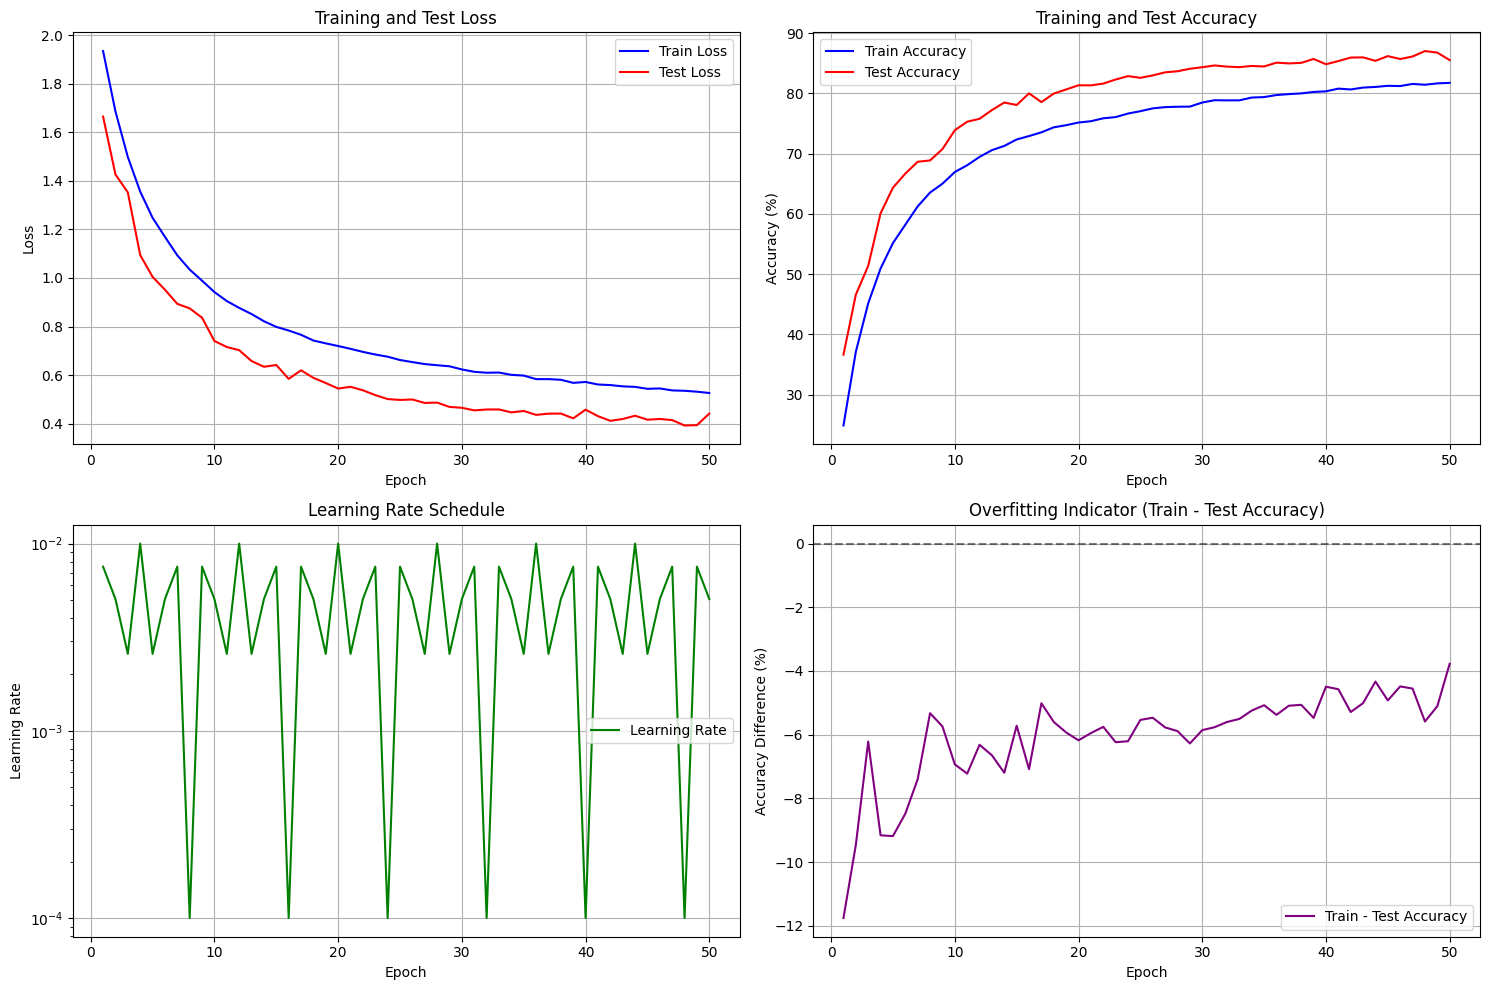

✅ Training plots generated


In [14]:
# Display training results
print("📊 Training Results:")
print("=" * 50)

best_train_acc = max(training_history['train_accuracies'])
best_test_acc = max(training_history['test_accuracies'])
final_train_acc = training_history['train_accuracies'][-1]
final_test_acc = training_history['test_accuracies'][-1]

print(f"Best Train Accuracy: {best_train_acc:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Total Epochs: {len(training_history['epochs'])}")
print(f"Target Achievement: {'✅' if best_test_acc >= config.target_accuracy else '❌'} ({config.target_accuracy}%)")

# Overfitting analysis
overfitting_gap = final_train_acc - final_test_acc
print(f"\nOverfitting Analysis:")
print(f"Train-Test Gap: {overfitting_gap:.2f}%")
if overfitting_gap > 5:
    print("⚠️  Potential overfitting detected")
elif overfitting_gap < 1:
    print("✅ Good generalization")
else:
    print("✅ Reasonable generalization")

# Plot training history
print("\n📈 Generating training plots...")
plot_training_history(training_history, show_plot=True)
print("✅ Training plots generated")
